# Binary Classification Deep Learning Model for Truck APS Failure Using TensorFlow Take 1
### David Lowe
### July 29, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Truck APS Failure dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: The dataset consists of data collected from heavy Scania trucks in everyday usage. The system in focus is the Air Pressure system (APS), which generates pressurized air that supports functions such as braking and gear changes. The dataset’s positive class consists of component failures for a specific component of the APS system. The negative class consists of trucks with failures for components not related to the APS. The training set contains 60000 examples in total, in which 59000 belong to the negative class and 1000 positive class. The test set contains 16000 examples.

The challenge is to minimize the total cost of a prediction model the sum of “Cost_1” multiplied by the number of Instances with type 1 failure and "Cost_2" with the number of instances with type 2 failure. The “Cost_1” variable refers to the cost resulted from a redundant check by a mechanic at the workshop. Meanwhile, the “Cost_2” variable refers to the cost of not catching a faulty truck. The cost of Type I error (cost_1) is 10, while the cost of the Type II error (cost_2) is 500.

In the previous Scikit-Learn iterations, we constructed and tuned machine learning models for this dataset using the Scikit-Learn and the XGboost libraries. We also observed the best accuracy result that we could obtain using the tuned models with the training, validation, and test datasets.

In this Take1 iteration, we will construct and tune machine learning models for this dataset using TensorFlow with three layers. We will observe the best accuracy result that we can obtain using the tuned models with the validation and test datasets.

ANALYSIS: From the previous Scikit-Learn iterations, the optimized XGBoost model processed the testing dataset with a recall metric of 98.66% with a low Type II error rate.

From this Take1 iteration, the performance of the three-layer TensorFlow model achieved a recall score of 77.20% with the training dataset. After a series of tuning trials, the TensorFlow model processed the validation dataset with a recall score of 75.20%, which was consistent with the prediction from the training result. When configured with the optimized parameters, the TensorFlow model processed the test dataset with a recall score of 55.46% with a high Type II error rate.

CONCLUSION: For this dataset, the model built using TensorFlow did not achieve a satisfactory result, but we should consider using TensorFlow to model further.

Dataset Used: APS Failure at Scania Trucks Data Set

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks

One potential source of performance benchmark: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Data
3. Define and Train Model
4. Evaluate and Optimize Model
5. Finalize Model and Make Predictions

# Task 1. Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
!pip install python-dotenv PyMySQL

     |████████████████████████████████| 51kB 2.9MB/s 


In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sat Jul 25 20:49:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Direct Colab to use TensorFlow v2
%tensorflow_version 2.x

In [5]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import math
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Check the number of GPUs accessible through TensorFlow
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useGDrive = False
if useGDrive:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the number of folds for cross validation
n_folds = 5

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set various default Keras modeling parameters
default_loss = keras.losses.BinaryCrossentropy()
# default_metrics = ['accuracy']
default_metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]
default_optimizer = keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = keras.initializers.he_uniform(seed=seedNum)
default_epoch = 50
default_batch = 64

# Define the labels to use for analyzing models
train_metric = "recall"
validation_metric = "val_recall"

# Business case metrics
cost_1 = 10
cost_2 = 500

Num GPUs Available:  1


In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None) or (topic_arn is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if (notifyStatus): status_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 2. Load and Prepare Data

In [12]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 2.a) Load Dataset

In [13]:
dataset_path = 'https://dainesanalytics.com/datasets/ucirvine-truck-aps-failure/aps_failure_training_set.csv'
Xy_original = pd.read_csv(dataset_path, sep=',', na_values="na", skiprows=19)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,0.0,5374.0,2108.0,4114.0,12348.0,615248.0,5526276.0,2378.0,4.0,0.0,0.0,2328746.0,1022304.0,415432.0,287230.0,310246.0,681504.0,1118814.0,3574.0,0.0,0.0,6700214.0,0.0,10.0,108.0,50.0,2551696.0,97518.0,947550.0,799478.0,330760.0,353400.0,299160.0,305200.0,283680.0,NaN,NaN,NaN,178540.0,76698.08,6700214.0,6700214.0,6599892.0,43566.0,68656.0,54064.0,638360.0,6167850.0,1209600.0,246244.0,2.0,96.0,0.0,5245752.00,0.00,916567.68,6.0,1924.0,0.0,0.0,0.0,118196.0,1309472.0,3247182.0,1381362.0,98822.0,11208.0,1608.0,220.0,240.0,6700214.0,NaN,10476.0,1226.0,267998.0,521832.0,428776.0,4015854.0,895240.0,26330.0,118.0,0.0,532.0,734.0,4122704.0,51288.0,0.0,532572.0,0.0,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,0.0,7336.0,7808.0,13776.0,13086.0,1010074.0,1873902.0,14726.0,6.0,0.0,0.0,1378576.0,447166.0,199512.0,154298.0,137280.0,138668.0,165908.0,229652.0,87082.0,4708.0,3646660.0,86.0,454.0,364.0,350.0,1393352.0,49028.0,688314.0,392208.0,341420.0,359780.0,366560.0,NaN,NaN,NaN,NaN,NaN,6700.0,33057.51,3646660.0,3646660.0,3582034.0,17733.0,260120.0,115626.0,6900.0,2942850.0,1209600.0,0.0,NaN,NaN,NaN,2291079.36,0.00,643536.96,0.0,0.0,0.0,0.0,38.0,98644.0,1179502.0,1286736.0,336388.0,36294.0,5192.0,56.0,NaN,0.0,3646660.0,NaN,6160.0,796.0,164860.0,350066.0,272956.0,1837600.0,301242.0,9148.0,22.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,1450312.0,0.0,1620.0,1156.0,1228.0,34250.0,1811606.0,710672.0,34.0,0.0,0.0,0.0,790690.0,672026.0,332340.0,254892.0,189596.0,135758.0,103552.0,81666.0,46.0,0.0,2673338.0,128.0,202.0,576.0,4.0,1234132.0,28804.0,160176.0,139730.0,137160.0,130

In [14]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 171 columns):
 #   Column  Dtype  
---  ------  -----  
 0   class   object 
 1   aa_000  int64  
 2   ab_000  float64
 3   ac_000  float64
 4   ad_000  float64
 5   ae_000  float64
 6   af_000  float64
 7   ag_000  float64
 8   ag_001  float64
 9   ag_002  float64
 10  ag_003  float64
 11  ag_004  float64
 12  ag_005  float64
 13  ag_006  float64
 14  ag_007  float64
 15  ag_008  float64
 16  ag_009  float64
 17  ah_000  float64
 18  ai_000  float64
 19  aj_000  float64
 20  ak_000  float64
 21  al_000  float64
 22  am_0    float64
 23  an_000  float64
 24  ao_000  float64
 25  ap_000  float64
 26  aq_000  float64
 27  ar_000  float64
 28  as_000  float64
 29  at_000  float64
 30  au_000  float64
 31  av_000  float64
 32  ax_000  float64
 33  ay_000  float64
 34  ay_001  float64
 35  ay_002  float64
 36  ay_003  float64
 37  ay_004  float64
 38  ay_005  float64
 39  ay_006  float64
 40  ay_

In [15]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

ab_000    46329
ac_000     3335
ad_000    14861
ae_000     2500
af_000     2500
ag_000      671
ag_001      671
ag_002      671
ag_003      671
ag_004      671
ag_005      671
ag_006      671
ag_007      671
ag_008      671
ag_009      671
ah_000      645
ai_000      629
aj_000      629
ak_000     4400
al_000      642
am_0        629
an_000      642
ao_000      589
ap_000      642
aq_000      589
ar_000     2723
as_000      629
at_000      629
au_000      629
av_000     2500
ax_000     2501
ay_000      671
ay_001      671
ay_002      671
ay_003      671
ay_004      671
ay_005      671
ay_006      671
ay_007      671
ay_008      671
ay_009      671
az_000      671
az_001      671
az_002      671
az_003      671
az_004      671
az_005      671
az_006      671
az_007      671
az_008      671
az_009      671
ba_000      688
ba_001      688
ba_002      688
ba_003      688
ba_004      688
ba_005      688
ba_006      688
ba_007      688
ba_008      688
ba_009      688
bb_000      645
bc_000  

In [16]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  850015


## 2.b) Data Cleaning

In [17]:
# Impute missing values
Xy_original.fillna(-99999.0, inplace=True)

# Convert columns from one data type to another
Xy_original['aa_000'] = Xy_original['aa_000'].astype('float')

# Take a peek at the dataframe after cleaning
Xy_original.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698.0,-99999.0,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,0.0,5374.0,2108.0,4114.0,12348.0,615248.0,5526276.0,2378.0,4.0,0.0,0.0,2328746.0,1022304.0,415432.0,287230.0,310246.0,681504.0,1118814.0,3574.0,0.0,0.0,6700214.0,0.0,10.0,108.0,50.0,2551696.0,97518.0,947550.0,799478.0,330760.0,353400.0,299160.0,305200.0,283680.0,-99999.0,-99999.0,-99999.0,178540.0,76698.08,6700214.0,6700214.0,6599892.0,43566.0,68656.0,54064.0,638360.0,6167850.0,1209600.0,246244.0,2.0,96.0,0.0,5245752.00,0.0,916567.68,6.0,1924.0,0.0,0.0,0.0,118196.0,1309472.0,3247182.0,1381362.0,98822.0,11208.0,1608.0,220.0,240.0,6700214.0,-99999.0,10476.0,1226.0,267998.0,521832.0,428776.0,4015854.0,895240.0,26330.0,118.0,0.0,532.0,734.0,4122704.0,51288.0,0.0,532572.0,0.0,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058.0,-99999.0,0.000000e+00,-99999.0,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,0.0,7336.0,7808.0,13776.0,13086.0,1010074.0,1873902.0,14726.0,6.0,0.0,0.0,1378576.0,447166.0,199512.0,154298.0,137280.0,138668.0,165908.0,229652.0,87082.0,4708.0,3646660.0,86.0,454.0,364.0,350.0,1393352.0,49028.0,688314.0,392208.0,341420.0,359780.0,366560.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,6700.0,33057.51,3646660.0,3646660.0,3582034.0,17733.0,260120.0,115626.0,6900.0,2942850.0,1209600.0,0.0,-99999.0,-99999.0,-99999.0,2291079.36,0.0,643536.96,0.0,0.0,0.0,0.0,38.0,98644.0,1179502.0,1286736.0,336388.0,36294.0,5192.0,56.0,-99999.0,0.0,3646660.0,-99999.0,6160.0,796.0,164860.0,350066.0,272956.0,1837600.0,301242.0,9148.0,22.0,0.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040.0,-99999.0,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,1450312.0,0.0,1620.0,1156.0,1228.0,34250.0,1811606.0,710672.0,34.0,0.0,0.0,0.0,790690.0,672026.0,332

In [18]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 171 columns):
 #   Column  Dtype  
---  ------  -----  
 0   class   object 
 1   aa_000  float64
 2   ab_000  float64
 3   ac_000  float64
 4   ad_000  float64
 5   ae_000  float64
 6   af_000  float64
 7   ag_000  float64
 8   ag_001  float64
 9   ag_002  float64
 10  ag_003  float64
 11  ag_004  float64
 12  ag_005  float64
 13  ag_006  float64
 14  ag_007  float64
 15  ag_008  float64
 16  ag_009  float64
 17  ah_000  float64
 18  ai_000  float64
 19  aj_000  float64
 20  ak_000  float64
 21  al_000  float64
 22  am_0    float64
 23  an_000  float64
 24  ao_000  float64
 25  ap_000  float64
 26  aq_000  float64
 27  ar_000  float64
 28  as_000  float64
 29  at_000  float64
 30  au_000  float64
 31  av_000  float64
 32  ax_000  float64
 33  ay_000  float64
 34  ay_001  float64
 35  ay_002  float64
 36  ay_003  float64
 37  ay_004  float64
 38  ay_005  float64
 39  ay_006  float64
 40  ay_

In [19]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [20]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 2.c) Splitting Data into Attributes-only and Target_only Sets

In [21]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [22]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (60000, 171) X_original.shape: (60000, 170) y_original.shape: (60000,)


In [23]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

## 2.d) Splitting Data into Training, Validation, and Test Sets

In [24]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [25]:
# Encode class values as integers
# y_encoded = y_original.to_numpy()
encoder = preprocessing.LabelEncoder()
encoder.fit(y_original)
y_encoded = encoder.transform(y_original)
print(y_encoded[0:19])

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [26]:
# Split the data further into training and validation datasets
X_train_df, X_validation_df, y_train, y_validation = train_test_split(X_original, y_encoded, test_size=val_set_size, stratify=y_original, random_state=seedNum)
print("X_train_df.shape: {} y_train.shape: {}".format(X_train_df.shape, y_train.shape))
print("X_validation_df.shape: {} y_validation.shape: {}".format(X_validation_df.shape, y_validation.shape))

X_train_df.shape: (45000, 170) y_train.shape: (45000,)
X_validation_df.shape: (15000, 170) y_validation.shape: (15000,)


In [27]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 2.e) Feature Scaling and Pre-processing

In [28]:
# Gather a list of features for applying the data pre-processing
columns_to_scale = X_train_df.columns[X_train_df.dtypes == 'float64'].tolist()
print('Columns to scale are:', columns_to_scale)

Columns to scale are: ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000', 'cl_000',

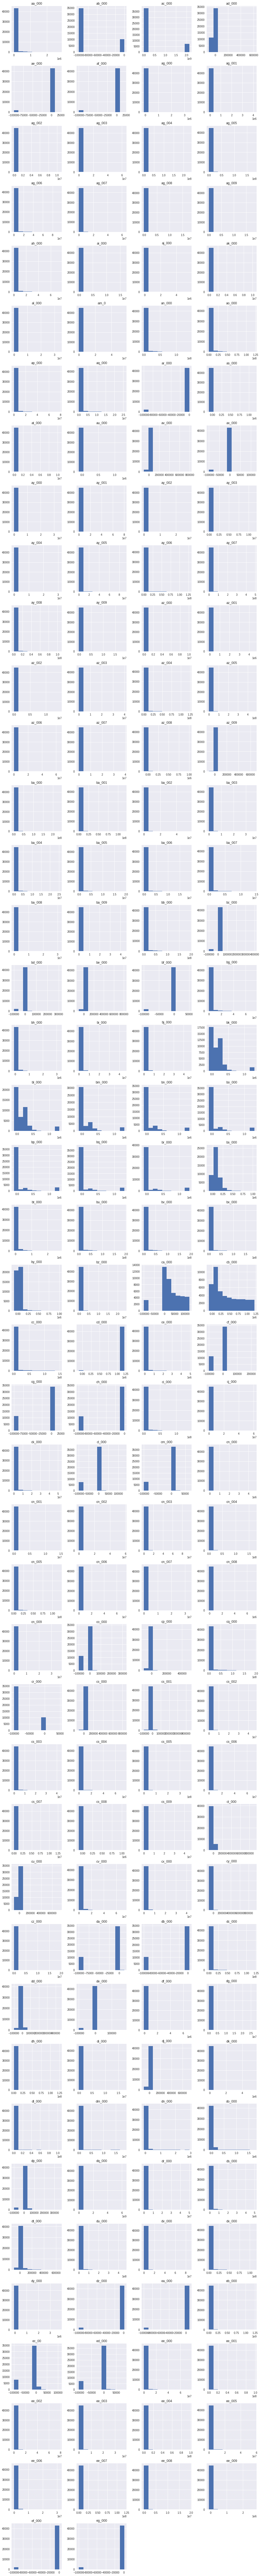

In [29]:
# Histograms for each attribute before pre-processing
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [30]:
# Apply feature scaling and transformation to the training dataset
scaler = preprocessing.MinMaxScaler()
scaled_features = scaler.fit_transform(X_train_df[columns_to_scale])
X_train_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_train_df.head())

         aa_000    ab_000    ac_000    ad_000    ae_000    af_000    ag_000    ag_001    ag_002    ag_003    ag_004    ag_005    ag_006  \
53184  0.000796  0.000000  0.000047  0.140483  0.826103  0.832846  0.028761  0.023974  0.010742  0.002150  0.000576  0.000911  0.001509   
38127  0.351795  0.997984  0.000057  0.140500  0.826103  0.832846  0.028761  0.023756  0.010820  0.055879  0.048248  0.050040  0.040355   
23467  0.000007  0.000000  0.000047  0.140396  0.826103  0.832846  0.028761  0.023756  0.009387  0.001575  0.000437  0.000578  0.001106   
34170  0.022194  0.000000  1.000000  0.140882  0.826103  0.832846  0.028761  0.023756  0.009387  0.001575  0.000617  0.009722  0.020297   
55321  0.000004  0.997964  0.000047  0.140404  0.826103  0.832846  0.028761  0.023756  0.009387  0.001607  0.000446  0.000571  0.001076   

         ag_007    ag_008    ag_009    ah_000    ai_000    aj_000    ak_000    al_000      am_0    an_000    ao_000    ap_000    aq_000  \
53184  0.001603  0.005617 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


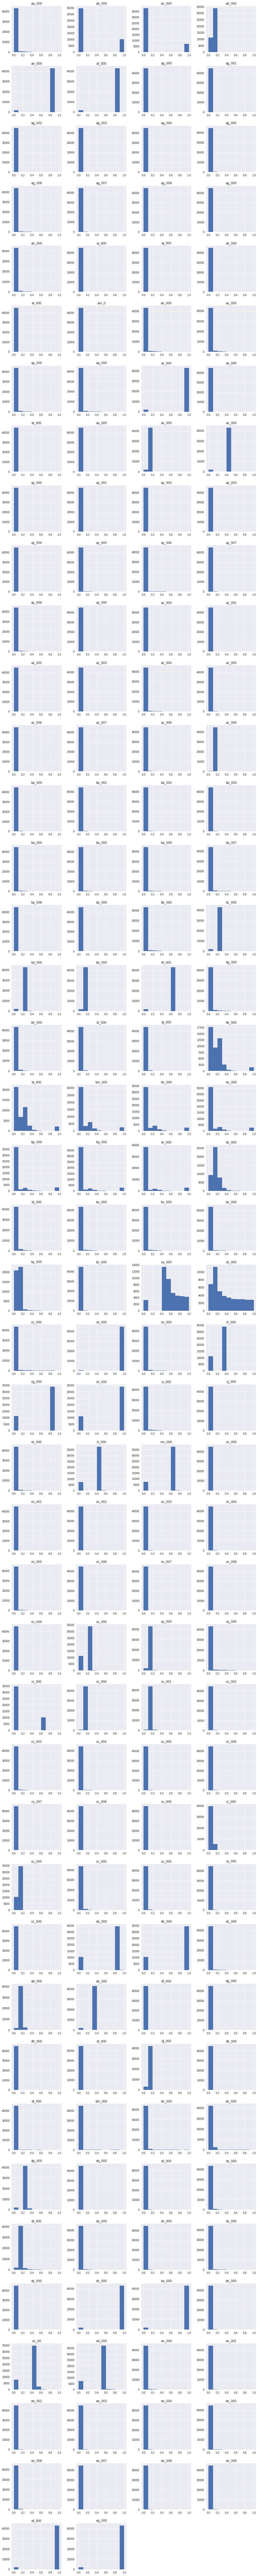

In [31]:
# Histograms for each attribute after pre-processing
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [32]:
# Apply feature scaling and transformation to the validation dataset
scaled_features = scaler.transform(X_validation_df[columns_to_scale])
X_validation_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_validation_df.head())

             aa_000    ab_000    ac_000    ad_000    ae_000    af_000    ag_000    ag_001    ag_002    ag_003    ag_004    ag_005  \
33395  7.092498e-04  0.000000  0.000047  0.140432  0.826103  0.832846  0.028761  0.023756  0.009387  0.001575  0.000536  0.000746   
24323  4.369095e-06  0.997964  0.000047  0.140404  0.826103  0.832846  0.028761  0.023756  0.009387  0.001585  0.000448  0.000565   
3712   7.281826e-07  0.000000  0.000047  0.140415  0.826103  0.832846  0.028761  0.023756  0.009387  0.001659  0.000454  0.000566   
56135  3.449182e-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.028761  0.023756  0.009387  0.001575  0.000993  0.014459   
7328   1.126790e-02  0.000000  0.000047  0.141109  0.826103  0.832846  0.028761  0.023756  0.009387  0.001575  0.000500  0.003284   

         ag_006    ag_007    ag_008    ag_009    ah_000    ai_000    aj_000    ak_000    al_000      am_0    an_000    ao_000    ap_000  \
33395  0.001645  0.001577  0.005617  0.005424  0.002046  0.006

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 2.f) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training datasets for the modeling activities
X_train = X_train_df.to_numpy()
X_validation = X_validation_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_validation.shape: {} y_validation.shape: {}".format(X_validation.shape, y_validation.shape))

X_train.shape: (45000, 170) y_train.shape: (45000,)
X_validation.shape: (15000, 170) y_validation.shape: (15000,)


# Task 3. Define and Train Model

In [34]:
if (notifyStatus): status_notify("Task 3. Define and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [35]:
# Define the baseline model for benchmarking
def create_nn_model(layer1_nodes=48, layer2_nodes=32, layer3_nodes=16, layer4_nodes=0, layer5_nodes=0, 
                    layer1_dropout=0, layer2_dropout=0, layer3_dropout=0, layer4_dropout=0, layer5_dropout=0, 
                    opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential()
    nn_model.add(keras.layers.Dense(layer1_nodes, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=init_param))
    nn_model.add(keras.layers.BatchNormalization())
    nn_model.add(keras.layers.Dropout(layer1_dropout))
    nn_model.add(keras.layers.Dense(layer2_nodes, activation='relu', kernel_initializer=init_param))
    nn_model.add(keras.layers.BatchNormalization())
    nn_model.add(keras.layers.Dropout(layer2_dropout))
    nn_model.add(keras.layers.Dense(layer3_nodes, activation='relu', kernel_initializer=init_param))
    nn_model.add(keras.layers.BatchNormalization())
    nn_model.add(keras.layers.Dropout(layer3_dropout))
    # nn_model.add(keras.layers.Dense(layer4_nodes, activation='relu', kernel_initializer=init_param))
    # nn_model.add(keras.layers.BatchNormalization())
    # nn_model.add(keras.layers.Dropout(layer4_dropout))
    # nn_model.add(keras.layers.Dense(layer5_nodes, activation='relu', kernel_initializer=init_param))
    # nn_model.add(keras.layers.BatchNormalization())
    # nn_model.add(keras.layers.Dropout(layer5_dropout))
    nn_model.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init_param))
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [36]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(2, 2, figsize=(24, 12))
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()

In [37]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model = create_nn_model()
baseline_history = baseline_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_validation, y_validation), verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/50
704/704 [==============================] - 6s 9ms/step - loss: 0.2042 - tp: 390.0000 - fp: 1531.0000 - tn: 42719.0000 - fn: 360.0000 - accuracy: 0.9580 - precision: 0.2030 - recall: 0.5200 - auc: 0.8621 - val_loss: 0.3681 - val_tp: 174.0000 - val_fp: 138.0000 - val_tn: 14612.0000 - val_fn: 76.0000 - val_accuracy: 0.9857 - val_precision: 0.5577 - val_recall: 0.6960 - val_auc: 0.9832
Epoch 2/50
704/704 [==============================] - 6s 8ms/step - loss: 0.0368 - tp: 365.0000 - fp: 155.0000 - tn: 44095.0000 - fn: 385.0000 - accuracy: 0.9880 - precision: 0.7019 - recall: 0.4867 - auc: 0.9770 - val_loss: 0.0332 - val_tp: 144.0000 - val_fp: 69.0000 - val_tn: 14681.0000 - val_fn: 106.0000 - val_accuracy: 0.9883 - val_precision: 0.6761 - val_recall: 0.5760 - val_auc: 0.9845
Epoch 3/50
704/704 [==============================] - 6s 8ms/step - loss: 0.0294 - tp: 427.0000 - fp: 123.0000 - tn: 44127.0000 - fn: 323.0000 - accuracy: 0.9901 - precision: 0.7764 - recall: 0.5693 - auc: 0.9

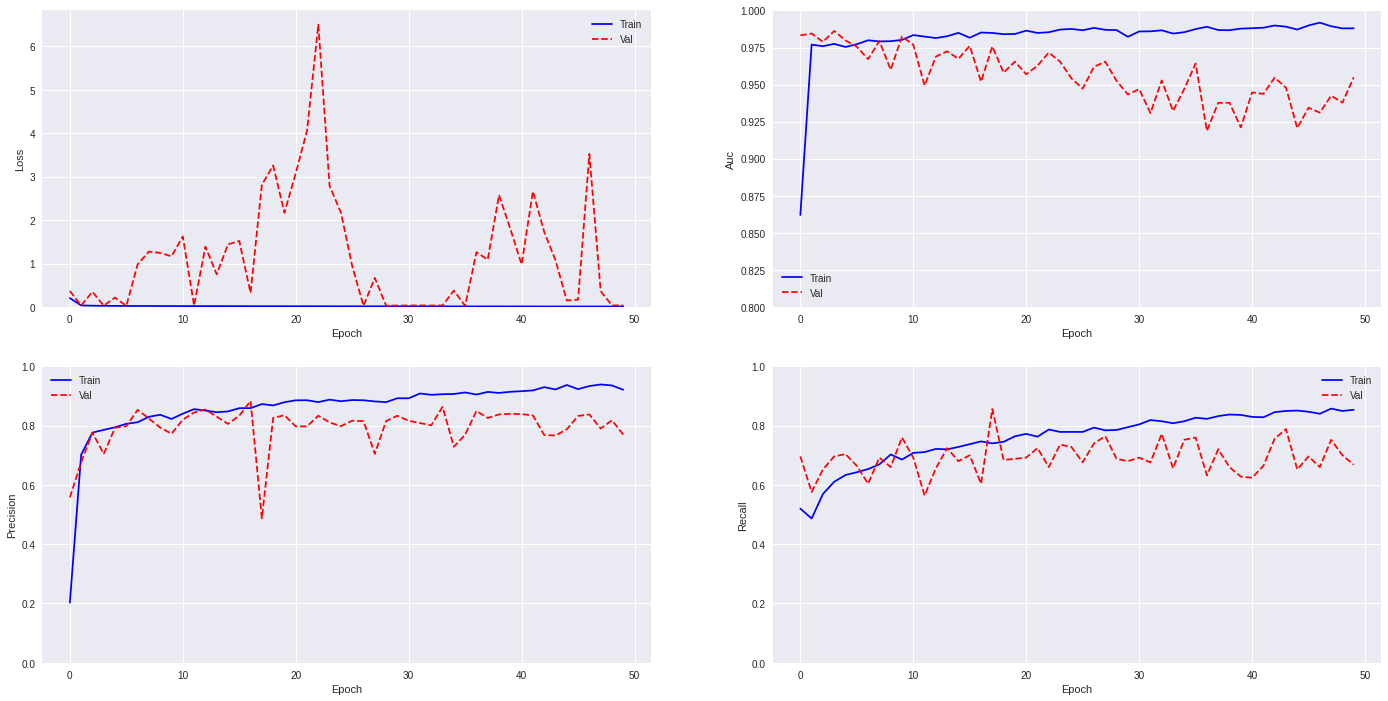

In [38]:
plot_metrics(baseline_history)

In [39]:
if (notifyStatus): status_notify("Task 3. Define and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 4. Evaluate and Optimize Model

In [40]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [41]:
# Initialize the grid parameters and fit the models
nodes_grid = [(72, 48, 24, 0, 0), (96, 48, 32, 0, 0), (144, 96, 48, 0, 0), (192, 128, 64, 0, 0), (240, 160, 80, 0, 0)]
layer1_dropout, layer2_dropout, layer3_dropout, layer4_dropout, layer5_dropout = (0, 0, 0, 0, 0)

# Build dataframe for reporting model performance summary
nodes_performance = pd.DataFrame(columns=['model_name', 'train_score', 'validation_score', 'variance', 'layer1_nodes', 'layer2_nodes', 'layer3_nodes', 'layer4_nodes',
                                          'layer5_nodes', 'layer1_dropout', 'layer2_dropout', 'layer3_dropout', 'layer4_dropout', 'layer5_dropout'])

serial_number = 0
for param in nodes_grid:
    startTimeModule = datetime.now()
    serial_number = serial_number + 1
    model_name = "Model_" + str(serial_number).zfill(3)
    layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes = param
    reset_random(seedNum)
    grid_search_model = create_nn_model(layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, layer2_dropout,
                                        layer3_dropout, layer4_dropout, layer5_dropout, default_optimizer, default_kernel_init)
    print('Processing model %s with Layer 1: %d, Layer 2: %d, Layer 3: %d, Layer 4: %d, and Layer 5: %d nodes' % (model_name, layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes))
    model_train_hist = grid_search_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_validation, y_validation), verbose=1)
    train_score = model_train_hist.history[train_metric][-1]
    validation_score = model_train_hist.history[validation_metric][-1]
    train_val_variance = abs(train_score - validation_score)
    print('The maximum score for the training dataset: %.2f%%' % (max(model_train_hist.history[train_metric])*100))
    print('The score at the last epoch for the training dataset: %.2f%%' % (train_score*100))
    print('The maximum score for the validation dataset: %.2f%%' % (max(model_train_hist.history[validation_metric])*100))
    print('The score at the last epoch for the validation dataset: %.2f%%' % (validation_score*100))
    print('The training vs. validation variance at the last epoch is: %.4f' % (train_val_variance))
    print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
    nodes_performance = nodes_performance.append({'model_name': model_name, 'train_score': train_score, 'validation_score': validation_score, 'variance': train_val_variance, 
                                                  'layer1_nodes': layer1_nodes, 'layer2_nodes': layer2_nodes, 'layer3_nodes': layer3_nodes, 'layer4_nodes': layer4_nodes,
                                                  'layer5_nodes': layer5_nodes, 'layer1_dropout': layer1_dropout, 'layer2_dropout': layer2_dropout, 'layer3_dropout': layer3_dropout,
                                                  'layer4_dropout': layer4_dropout, 'layer5_dropout': layer5_dropout}, ignore_index=True)

nodes_performance.set_index('model_name', inplace=True)

Processing model Model_001 with Layer 1: 72, Layer 2: 48, Layer 3: 24, Layer 4: 0, and Layer 5: 0 nodes
Epoch 1/50
704/704 [==============================] - 7s 9ms/step - loss: 0.0705 - tp: 471.0000 - fp: 551.0000 - tn: 58449.0000 - fn: 529.0000 - accuracy: 0.9820 - precision: 0.4609 - recall: 0.4710 - auc: 0.9428 - val_loss: 0.5757 - val_tp: 158.0000 - val_fp: 40.0000 - val_tn: 14710.0000 - val_fn: 92.0000 - val_accuracy: 0.9912 - val_precision: 0.7980 - val_recall: 0.6320 - val_auc: 0.9861
Epoch 2/50
704/704 [==============================] - 6s 8ms/step - loss: 0.0292 - tp: 413.0000 - fp: 132.0000 - tn: 44118.0000 - fn: 337.0000 - accuracy: 0.9896 - precision: 0.7578 - recall: 0.5507 - auc: 0.9770 - val_loss: 0.0272 - val_tp: 177.0000 - val_fp: 83.0000 - val_tn: 14667.0000 - val_fn: 73.0000 - val_accuracy: 0.9896 - val_precision: 0.6808 - val_recall: 0.7080 - val_auc: 0.9867
Epoch 3/50
704/704 [==============================] - 6s 8ms/step - loss: 0.0260 - tp: 459.0000 - fp: 125.00

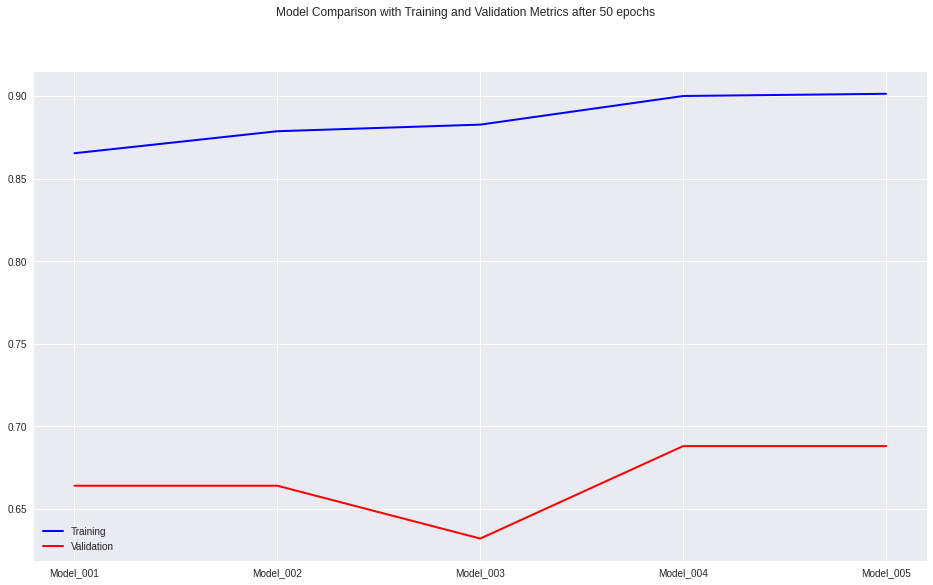

In [42]:
# Spot-checking the models
fig = plt.figure(figsize=(16,9))
title = 'Model Comparison with Training and Validation Metrics after ' + str(default_epoch) + ' epochs'
fig.suptitle(title)
ax1 = fig.add_subplot(111)
ax1.plot(nodes_performance['train_score'], color='b', lw=2.)
ax1.plot(nodes_performance['validation_score'], color='r', lw=2.)
plt.legend(['Training', 'Validation'], loc='lower left')
plt.show()

In [43]:
# Initialize the grid parameters for the dropout ratio
startTimeModule = datetime.now()
model_to_use = 'Model_004'
layer1_nodes = nodes_performance.loc[model_to_use]['layer1_nodes']
layer2_nodes = nodes_performance.loc[model_to_use]['layer2_nodes']
layer3_nodes = nodes_performance.loc[model_to_use]['layer3_nodes']
layer4_nodes = nodes_performance.loc[model_to_use]['layer4_nodes']
layer5_nodes = nodes_performance.loc[model_to_use]['layer5_nodes']
layer1_dropout_grid = [0.2, 0.35, 0.5]
layer2_dropout_grid = [0.2, 0.35, 0.5]
layer3_dropout_grid = [0.35, 0.5]
layer4_dropout_grid = [0]
layer5_dropout_grid = [0]

# Build dataframe for reporting model performance summary
dropout_performance = pd.DataFrame(columns=['model_name','train_score','validation_score','variance','layer1_nodes','layer2_nodes','layer3_nodes','layer4_nodes',
                                            'layer5_nodes','layer1_dropout','layer2_dropout','layer3_dropout','layer4_dropout','layer5_dropout'])

serial_number = 0
for layer1_dropout in layer1_dropout_grid:
    for layer2_dropout in layer2_dropout_grid:
        for layer3_dropout in layer3_dropout_grid:
            for layer4_dropout in layer4_dropout_grid:
                for layer5_dropout in layer5_dropout_grid:
                    startTimeIteration = datetime.now()
                    serial_number = serial_number + 1
                    model_name = "Model_" + str(serial_number).zfill(3)
                    reset_random(seedNum)
                    grid_search_model = create_nn_model(layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, layer2_dropout,
                                                        layer3_dropout, layer4_dropout, layer5_dropout, default_optimizer, default_kernel_init)
                    print('Processing model %s with Layer 1: %d, Layer 2: %d, Layer 3: %d, Layer 4: %d, and Layer 5: %d nodes and dropout parameters of Layer 1: %.2f, Layer 2: %.2f, Layer 3: %.2f, Layer 4: %.2f, and Layer 5: %.2f' %
                        (model_name, layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, layer2_dropout, layer3_dropout, layer4_dropout, layer5_dropout))
                    model_train_hist = grid_search_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_validation, y_validation), verbose=0)
                    train_score = model_train_hist.history[train_metric][-1]
                    validation_score = model_train_hist.history[validation_metric][-1]
                    train_val_variance = abs(train_score - validation_score)
                    print('The maximum score for the training dataset: %.2f%%' % (max(model_train_hist.history[train_metric])*100))
                    print('The score at the last epoch for the training dataset: %.2f%%' % (train_score*100))
                    print('The maximum score for the validation dataset: %.2f%%' % (max(model_train_hist.history[validation_metric])*100))
                    print('The score at the last epoch for the validation dataset: %.2f%%' % (validation_score*100))
                    print('The training vs. validation variance at the last epoch is: %.4f' % (train_val_variance))
                    print('Total time for model fitting:', (datetime.now() - startTimeIteration), '\n')
                    dropout_performance = dropout_performance.append({'model_name': model_name, 'train_score': train_score, 'validation_score': validation_score, 'variance': train_val_variance,
                                                                    'layer1_nodes': layer1_nodes, 'layer2_nodes': layer2_nodes, 'layer3_nodes': layer3_nodes, 'layer4_nodes': layer4_nodes,
                                                                    'layer5_nodes': layer5_nodes, 'layer1_dropout': layer1_dropout, 'layer2_dropout': layer2_dropout, 'layer3_dropout': layer3_dropout,
                                                                    'layer4_dropout': layer4_dropout, 'layer5_dropout': layer5_dropout}, ignore_index=True)

dropout_performance.set_index('model_name', inplace=True)
print('Total time for performing grid-search of the best dropout parameters:', (datetime.now() - startTimeModule))

Processing model Model_001 with Layer 1: 192, Layer 2: 128, Layer 3: 64, Layer 4: 0, and Layer 5: 0 nodes and dropout parameters of Layer 1: 0.20, Layer 2: 0.20, Layer 3: 0.35, Layer 4: 0.00, and Layer 5: 0.00
The maximum score for the training dataset: 81.73%
The score at the last epoch for the training dataset: 80.13%
The maximum score for the validation dataset: 79.60%
The score at the last epoch for the validation dataset: 71.60%
The training vs. validation variance at the last epoch is: 0.0853
Total time for model fitting: 0:03:31.899238 

Processing model Model_002 with Layer 1: 192, Layer 2: 128, Layer 3: 64, Layer 4: 0, and Layer 5: 0 nodes and dropout parameters of Layer 1: 0.20, Layer 2: 0.20, Layer 3: 0.50, Layer 4: 0.00, and Layer 5: 0.00
The maximum score for the training dataset: 81.07%
The score at the last epoch for the training dataset: 78.80%
The maximum score for the validation dataset: 77.60%
The score at the last epoch for the validation dataset: 69.20%
The trainin

In [44]:
# Display the model performance summary by validation score
dropout_performance.sort_values(by=['validation_score'], ascending=False).head()

,train_score,validation_score,variance,layer1_nodes,layer2_nodes,layer3_nodes,layer4_nodes,layer5_nodes,layer1_dropout,layer2_dropout,layer3_dropout,layer4_dropout,layer5_dropout
model_name,,,,,,,,,,,,,
Model_008,0.744000,0.772,0.028000,192,128,64,0,0,0.35,0.20,0.50,0,0
Model_001,0.801333,0.716,0.085333,192,128,64,0,0,0.20,0.20,0.35,0,0
Model_003,0.793333,0.712,0.081333,192,128,64,0,0,0.20,0.35,0.35,0,0
Model_006,0.758667,0.700,0.058667,192,128,64,0,0,0.20,0.50,0.50,0,0
Model_009,0.740000,0.700,0.040000,192,128,64,0,0,0.35,0.35,0.35,0,0


In [45]:
# Display the model performance summary by variance
dropout_performance.sort_values(by=['variance']).head()

,train_score,validation_score,variance,layer1_nodes,layer2_nodes,layer3_nodes,layer4_nodes,layer5_nodes,layer1_dropout,layer2_dropout,layer3_dropout,layer4_dropout,layer5_dropout
model_name,,,,,,,,,,,,,
Model_008,0.744000,0.772,0.028000,192,128,64,0,0,0.35,0.20,0.50,0,0
Model_016,0.700000,0.660,0.040000,192,128,64,0,0,0.50,0.35,0.50,0,0
Model_009,0.740000,0.700,0.040000,192,128,64,0,0,0.35,0.35,0.35,0,0
Model_012,0.725333,0.684,0.041333,192,128,64,0,0,0.35,0.50,0.50,0,0
Model_014,0.726667,0.684,0.042667,192,128,64,0,0,0.50,0.20,0.50,0,0


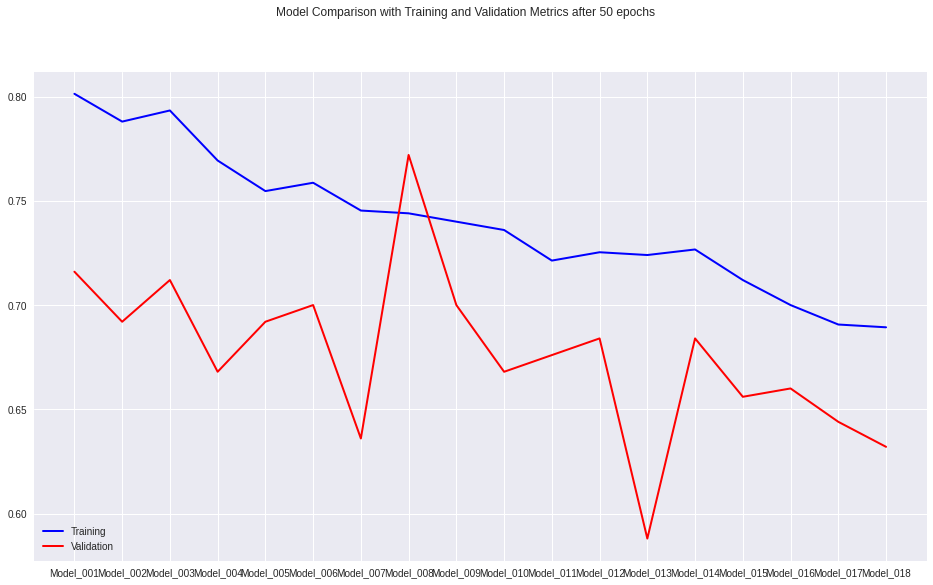

In [46]:
# Spot-checking the models
fig = plt.figure(figsize=(16,9))
title = 'Model Comparison with Training and Validation Metrics after ' + str(default_epoch) + ' epochs'
fig.suptitle(title)
ax1 = fig.add_subplot(111)
ax1.plot(dropout_performance['train_score'], color='b', lw=2.)
ax1.plot(dropout_performance['validation_score'], color='r', lw=2.)
plt.legend(['Training', 'Validation'], loc='lower left')
plt.show()

In [47]:
# Initialize the grid parameters for the optimizer, kernel, and batch size
startTimeModule = datetime.now()
model_to_use = 'Model_008'
layer1_nodes = dropout_performance.loc[model_to_use]['layer1_nodes']
layer2_nodes = dropout_performance.loc[model_to_use]['layer2_nodes']
layer3_nodes = dropout_performance.loc[model_to_use]['layer3_nodes']
layer4_nodes = dropout_performance.loc[model_to_use]['layer4_nodes']
layer5_nodes = dropout_performance.loc[model_to_use]['layer5_nodes']
layer1_dropout = dropout_performance.loc[model_to_use]['layer1_dropout']
layer2_dropout = dropout_performance.loc[model_to_use]['layer2_dropout']
layer3_dropout = dropout_performance.loc[model_to_use]['layer3_dropout']
layer4_dropout = dropout_performance.loc[model_to_use]['layer4_dropout']
layer5_dropout = dropout_performance.loc[model_to_use]['layer5_dropout']

# Set up grid search using different epochs, batch sizes, and optimizers
optz_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optz_2 = tf.keras.optimizers.RMSprop(learning_rate=0.001)
optz_3 = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer_grid = [optz_1, optz_2, optz_3]
print('Optimizer candidate #1 has the object ID of', optz_1)
print('Optimizer candidate #2 has the object ID of', optz_2)
print('Optimizer candidate #3 has the object ID of', optz_3)

init_1 = tf.keras.initializers.he_uniform(seed=seedNum)
init_2 = tf.keras.initializers.Orthogonal(seed=seedNum)
init_3 = tf.keras.initializers.RandomUniform(seed=seedNum)
init_grid = [init_1, init_2, init_3]
print('Initializer candidate #1 has the object ID of', init_1)
print('Initializer candidate #2 has the object ID of', init_2)
print('Initializer candidate #3 has the object ID of', init_3)

epoch_grid = [default_epoch]
batch_grid = [default_batch]

grid_iteration = 1
best_score = 0
best_iteration = 0
best_optimizer = default_optimizer
best_kernel_init = default_kernel_init
best_epoch = default_epoch
best_batch = default_batch

for optimizer in optimizer_grid:
    for kernel_init in init_grid:
        for epoch_num in epoch_grid:
            for batch_num in batch_grid:
                startTimeIteration = datetime.now()
                print('\nForming the grid-search model #%d using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
                      % (grid_iteration, optimizer, kernel_init, epoch_num, batch_num))
                reset_random(seedNum)
                grid_model = create_nn_model(layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, layer2_dropout, 
                                             layer3_dropout, layer4_dropout, layer5_dropout, optimizer, kernel_init)
                grid_hist = grid_model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_num, validation_data=(X_validation, y_validation), verbose=0)
                train_score = grid_hist.history[train_metric][-1]
                validation_score = grid_hist.history[validation_metric][-1]
                train_val_variance = abs(train_score - validation_score)
                print('The maximum score for the training dataset: %.2f%%' % (max(grid_hist.history[train_metric])*100))
                print('The score at the last epoch for the training dataset: %.2f%%' % (train_score*100))
                print('The maximum score for the validation dataset: %.2f%%' % (max(grid_hist.history[validation_metric])*100))
                print('The score at the last epoch for the validation dataset: %.2f%%' % (validation_score*100))
                print('The training vs. validation variance at the last epoch is: %.4f' % (train_val_variance))
                print('Total time for model fitting:', (datetime.now() - startTimeIteration), '\n')
                if(grid_hist.history[validation_metric][-1] > best_score):
                    best_score = grid_hist.history[validation_metric][-1]
                    best_iteration = grid_iteration
                    best_optimizer = optimizer
                    best_kernel_init = kernel_init
                    best_epoch = epoch_num
                    best_batch = batch_num
                grid_iteration = grid_iteration + 1

# summarize results
print("\nBest score (from validation) found via grid search: %f from model iteration #%d"
      % (best_score, best_iteration))
print('The best modeling parameters are: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))


Optimizer candidate #1 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f354398a5c0>
Optimizer candidate #2 has the object ID of <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7f354398ad68>
Optimizer candidate #3 has the object ID of <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f354398af98>
Initializer candidate #1 has the object ID of <tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7f354398abe0>
Initializer candidate #2 has the object ID of <tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7f354398af60>
Initializer candidate #3 has the object ID of <tensorflow.python.ops.init_ops_v2.RandomUniform object at 0x7f354398acf8>

Forming the grid-search model #1 using: optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f354398a5c0>, kernel=<tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7f354398abe0>, epochs=50, batch_size=64
The maximum score for the train

In [48]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 5. Finalize Model and Make Predictions

In [49]:
if (notifyStatus): status_notify("Task 5. Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
# Combining the training and validation datasets to form the dataset that will be used for training the final model
X_train_val = np.vstack((X_train, X_validation))
y_train_val = np.concatenate((y_train, y_validation))
print("X_train_val.shape: {} y_train_val.shape: {}".format(X_train_val.shape, y_train_val.shape))

X_train_val.shape: (60000, 170) y_train_val.shape: (60000,)


In [51]:
# Create the final model for evaluating the test dataset
final_optimizer = best_optimizer
final_kernel_init = best_kernel_init
final_epoch = best_epoch
final_batch = best_batch
print('Processing model %s with Layer 1: %d, Layer 2: %d, Layer 3: %d, Layer 4: %d, and Layer 5: %d nodes and dropout parameters of Layer 1: %.2f, Layer 2: %.2f, Layer 3: %.2f, Layer 4: %.2f, and Layer 5: %.2f' % 
      (model_name, layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, layer2_dropout, layer3_dropout, layer4_dropout, layer5_dropout))
print('The final modeling parameters are: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d' % (best_optimizer, best_kernel_init, best_epoch, best_batch))
reset_random(seedNum)
final_model = create_nn_model(layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, layer2_dropout, layer3_dropout, layer4_dropout, layer5_dropout, final_optimizer, final_kernel_init)
final_model.fit(X_train_val, y_train_val, epochs=default_epoch, batch_size=default_batch, verbose=0)

# Display a summary of the final model
print(final_model.summary())

Processing model Model_018 with Layer 1: 192, Layer 2: 128, Layer 3: 64, Layer 4: 0, and Layer 5: 0 nodes and dropout parameters of Layer 1: 0.35, Layer 2: 0.20, Layer 3: 0.50, Layer 4: 0.00, and Layer 5: 0.00
The final modeling parameters are: optimizer=<tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f354398af98>, kernel=<tensorflow.python.ops.init_ops_v2.RandomUniform object at 0x7f354398acf8>, epochs=50, batch_size=64
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 192)               32832     
_________________________________________________________________
batch_normalization_99 (Batc (None, 192)               768       
_________________________________________________________________
dropout_99 (Dropout)         (None, 192)               0         
_________________________________________________________________


In [52]:
dataset_path = 'https://dainesanalytics.com/datasets/ucirvine-truck-aps-failure/aps_failure_test_set.csv'
Xy_test = pd.read_csv(dataset_path, sep=',', na_values="na", skiprows=19)

# Take a peek at the dataframe after import
Xy_test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,3862.0,1846.0,0.0,0.0,0.0,3976.0,0.0,0.0,0.0,1520.0,2374.0,11516.0,9480.0,111258.0,470.0,0.0,0.0,0.0,0.0,58.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13124.0,2.0,1956.0,434.0,76.0,174.0,190.0,6198.0,1148.0,2948.0,2.0,0.0,8762.0,2566.0,480.0,380.0,196.0,516.0,86.0,66.0,74.0,0.0,124340.0,4.0,6.0,4.0,0.0,3976.0,318.0,107662.0,3458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110980.0,59.53,124340.0,124340.0,184970.0,54.0,686.0,12246.0,123880.0,13196.0,1209600.0,598.0,0.0,6.0,0.0,5913.60,0.00,5851.20,6.0,30.0,0.0,2.0,5512.0,4674.0,1388.0,1508.0,38.0,4.0,0.0,0.0,8.0,12.0,124340.0,0.0,1550.0,14.0,36.0,26.0,920.0,430.0,7650.0,2294.0,206.0,0.0,22.0,42.0,5336.0,1276.0,0.0,0.0,0.0,0.0,6598.0,70.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.0,0.0,0.0,1100.0,574.0,232.0,66.0,780.0,882.0,0.0,4.0,0.0,0.0,0.0,465.50,90.0,7502.0,3156.0,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,12594.0,3636.0,0.0,0.0,0.0,5244.0,0.0,60.0,0.0,0.0,0.0,23174.0,18166.0,23686.0,1270.0,0.0,0.0,0.0,0.0,12.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,692.0,16286.0,0.0,280.0,44.0,50.0,1274.0,866.0,3362.0,11102.0,0.0,0.0,0.0,12564.0,1756.0,638.0,276.0,172.0,132.0,812.0,308.0,192.0,128.0,46894.0,4.0,2.0,38.0,0.0,5244.0,360.0,20520.0,3134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23320.0,81.89,46894.0,46894.0,48324.0,68.0,0.0,4486.0,46480.0,17050.0,1209600.0,726.0,2.0,4.0,0.0,7224.96,0.00,7768.32,0.0,42.0,0.0,0.0,4.0,7064.0,6200.0,2452.0,1246.0,12.0,0.0,0.0,14.0,54.0,46894.0,0.0,2202.0,28.0,114.0,350.0,700.0,1708.0,9622.0,2174.0,80.0,0.0,80.0,206.0,7802.0,1466.0,0.0,0.0,0.0,0.0,7918.0,78.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.0,0.0,0.0,3996.0,584.0,200.0,62.0,37580.0,3756.0,6368.0,36.0,0.0,0.0,0.0,2.86,102.0,10040.0,3310.0,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,1952422.0,452706.0,25130.0,520.0,0.0,1891670.0,0.0,0.0,0.0,77898.0,110548.0,3605894.0,3291610.0,959756.0,286536.0,0.0,0.0,0.0,0.0,106.0,340.0,0.0,0.0,0.0,0.0,0.0,24286.0,681260.0,2808472.0,474782.0,0.0,22984.0,894.0,1162.0,1304.0,1856.0,388700.0,3424812.0,123828.0,23260.0,0.0,1662580.0,667960.0,387998.0,226078.0,161558.0,148288.0,154908.0,220820.0,147744.0,210866.0,4644422.0,958.0,7848.0,3624.0,0.0,1891670.0,47066.0,692800.0,265492.0,336240.0,194360.0,245240.0,NaN,NaN,NaN,NaN,NaN,175480.0,66002.89,4644422.0,4644422.0,4608738.0,22706.0,2272.0,95510.0,1006260.0,3991552.0,1209600.0,126310.0,0.0,104.0,0.0,3594885.12,0.00,374649.60,148.0,720.0,0.0,5154.0,174956.0,622312.0,1002504.0,793938.0,541734.0,345896.0,300806.0,201500.0,52.0,92.0,4644422.0,0.0,24818.0,964.0,162660.0,215004.0,217930.0,3038612.0,322718.0,6080.0,14.0,0.0,226.0,572.0,3593728.0,1911060.0,0.0,284.0,0.0,0.0,3613906.0,

In [53]:
Xy_test.isnull().sum()

class         0
aa_000        0
ab_000    12363
ac_000      926
ad_000     3981
ae_000      690
af_000      690
ag_000      189
ag_001      189
ag_002      189
ag_003      189
ag_004      189
ag_005      189
ag_006      189
ag_007      189
ag_008      189
ag_009      189
ah_000      175
ai_000      163
aj_000      163
ak_000     1198
al_000      169
am_0        163
an_000      169
ao_000      162
ap_000      169
aq_000      162
ar_000      764
as_000      163
at_000      163
au_000      163
av_000      688
ax_000      688
ay_000      192
ay_001      192
ay_002      192
ay_003      192
ay_004      192
ay_005      192
ay_006      192
ay_007      192
ay_008      192
ay_009      192
az_000      192
az_001      192
az_002      192
az_003      192
az_004      192
az_005      192
az_006      192
az_007      192
az_008      192
az_009      192
ba_000      193
ba_001      193
ba_002      193
ba_003      193
ba_004      193
ba_005      193
ba_006      193
ba_007      193
ba_008      193
ba_009  

In [54]:
print('Total number of NaN in the dataframe: ', Xy_test.isnull().sum().sum())

Total number of NaN in the dataframe:  228680


In [55]:
# Impute missing values
Xy_test.fillna(-99999.0, inplace=True)

# Convert columns from one data type to another
Xy_test['aa_000'] = Xy_test['aa_000'].astype('float')

# Take a peek at the dataframe after cleaning
Xy_test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60.0,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,3862.0,1846.0,0.0,0.0,0.0,3976.0,0.0,0.0,0.0,1520.0,2374.0,11516.0,9480.0,111258.0,470.0,0.0,0.0,0.0,0.0,58.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13124.0,2.0,1956.0,434.0,76.0,174.0,190.0,6198.0,1148.0,2948.0,2.0,0.0,8762.0,2566.0,480.0,380.0,196.0,516.0,86.0,66.0,74.0,0.0,124340.0,4.0,6.0,4.0,0.0,3976.0,318.0,107662.0,3458.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,110980.0,59.53,124340.0,124340.0,184970.0,54.0,686.0,12246.0,123880.0,13196.0,1209600.0,598.0,0.0,6.0,0.0,5913.60,0.00,5851.20,6.0,30.0,0.0,2.0,5512.0,4674.0,1388.0,1508.0,38.0,4.0,0.0,0.0,8.0,12.0,124340.0,0.0,1550.0,14.0,36.0,26.0,920.0,430.0,7650.0,2294.0,206.0,0.0,22.0,42.0,5336.0,1276.0,0.0,0.0,0.0,0.0,6598.0,70.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.0,0.0,0.0,1100.0,574.0,232.0,66.0,780.0,882.0,0.0,4.0,0.0,0.0,0.0,465.50,90.0,7502.0,3156.0,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82.0,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,12594.0,3636.0,0.0,0.0,0.0,5244.0,0.0,60.0,0.0,0.0,0.0,23174.0,18166.0,23686.0,1270.0,0.0,0.0,0.0,0.0,12.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,692.0,16286.0,0.0,280.0,44.0,50.0,1274.0,866.0,3362.0,11102.0,0.0,0.0,0.0,12564.0,1756.0,638.0,276.0,172.0,132.0,812.0,308.0,192.0,128.0,46894.0,4.0,2.0,38.0,0.0,5244.0,360.0,20520.0,3134.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,23320.0,81.89,46894.0,46894.0,48324.0,68.0,0.0,4486.0,46480.0,17050.0,1209600.0,726.0,2.0,4.0,0.0,7224.96,0.00,7768.32,0.0,42.0,0.0,0.0,4.0,7064.0,6200.0,2452.0,1246.0,12.0,0.0,0.0,14.0,54.0,46894.0,0.0,2202.0,28.0,114.0,350.0,700.0,1708.0,9622.0,2174.0,80.0,0.0,80.0,206.0,7802.0,1466.0,0.0,0.0,0.0,0.0,7918.0,78.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.0,0.0,0.0,3996.0,584.0,200.0,62.0,37580.0,3756.0,6368.0,36.0,0.0,0.0,0.0,2.86,102.0,10040.0,3310.0,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002.0,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,1952422.0,452706.0,25130.0,520.0,0.0,1891670.0,0.0,0.0,0.0,77898.0,110548.0,3605894.0,3291610.0,959756.0,286536.0,0.0,0.0,0.0,0.0,106.0,340.0,0.0,0.0,0.0,0.0,0.0,24286.0,681260.0,2808472.0,474782.0,0.0,22984.0,894.0,1162.0,1304.0,1856.0,388700.0,3424812.0,123828.0,23260.0,0.0,1662580.0,667960.0,387998.0,226078.0,161558.0,148288.0,154908.0,220820.0,147744.0,210866.0,4644422.0,958.0,7848.0,3624.0,0.0,1891670.0,47066.0,692800.0,265492.0,336240.0,194360.0,245240.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,175480.0,66002.89,4644422.0,4644422.0,4608738.0,22706.0,2272.0,95510.0,1006260.0,3991552.0,1209600.0,126310.0,0.0,104.0,0.0,3594885.12,0.00,374649.60,148.0,720.0,0.0,5154.0,174956.0,622312.0,1002504.0,793938.0,541734.0,345896.0,300806.0,201500.0,52.0,92.0,4644422.0,0.0,24818.0,964.0,162660.0,21

In [56]:
Xy_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 171 columns):
 #   Column  Dtype  
---  ------  -----  
 0   class   object 
 1   aa_000  float64
 2   ab_000  float64
 3   ac_000  float64
 4   ad_000  float64
 5   ae_000  float64
 6   af_000  float64
 7   ag_000  float64
 8   ag_001  float64
 9   ag_002  float64
 10  ag_003  float64
 11  ag_004  float64
 12  ag_005  float64
 13  ag_006  float64
 14  ag_007  float64
 15  ag_008  float64
 16  ag_009  float64
 17  ah_000  float64
 18  ai_000  float64
 19  aj_000  float64
 20  ak_000  float64
 21  al_000  float64
 22  am_0    float64
 23  an_000  float64
 24  ao_000  float64
 25  ap_000  float64
 26  aq_000  float64
 27  ar_000  float64
 28  as_000  float64
 29  at_000  float64
 30  au_000  float64
 31  av_000  float64
 32  ax_000  float64
 33  ay_000  float64
 34  ay_001  float64
 35  ay_002  float64
 36  ay_003  float64
 37  ay_004  float64
 38  ay_005  float64
 39  ay_006  float64
 40  ay_

In [57]:
print(Xy_test.describe())

             aa_000        ab_000        ac_000        ad_000        ae_000        af_000         ag_000        ag_001        ag_002  \
count  1.600000e+04  16000.000000  1.600000e+04  16000.000000  16000.000000  16000.000000   16000.000000  1.600000e+04  1.600000e+04   
mean   6.799698e+04 -77267.801812  3.373120e+08 -24550.855188  -4306.305750  -4302.700625   -1061.807313  8.585821e+02  1.244820e+04   
std    5.035350e+05  41910.822592  7.778065e+08  43444.234143  20315.912635  20317.007863   12577.258025  8.941163e+04  2.347655e+05   
min    0.000000e+00 -99999.000000 -9.999900e+04 -99999.000000 -99999.000000 -99999.000000  -99999.000000 -9.999900e+04 -9.999900e+04   
25%    9.280000e+02 -99999.000000  8.000000e+00      0.000000      0.000000      0.000000       0.000000  0.000000e+00  0.000000e+00   
50%    3.098200e+04 -99999.000000  1.240000e+02     42.000000      0.000000      0.000000       0.000000  0.000000e+00  0.000000e+00   
75%    4.947900e+04 -99999.000000  8.520000e+02 

In [58]:
Xy_test.isnull().sum()

class     0
aa_000    0
ab_000    0
ac_000    0
ad_000    0
ae_000    0
af_000    0
ag_000    0
ag_001    0
ag_002    0
ag_003    0
ag_004    0
ag_005    0
ag_006    0
ag_007    0
ag_008    0
ag_009    0
ah_000    0
ai_000    0
aj_000    0
ak_000    0
al_000    0
am_0      0
an_000    0
ao_000    0
ap_000    0
aq_000    0
ar_000    0
as_000    0
at_000    0
au_000    0
av_000    0
ax_000    0
ay_000    0
ay_001    0
ay_002    0
ay_003    0
ay_004    0
ay_005    0
ay_006    0
ay_007    0
ay_008    0
ay_009    0
az_000    0
az_001    0
az_002    0
az_003    0
az_004    0
az_005    0
az_006    0
az_007    0
az_008    0
az_009    0
ba_000    0
ba_001    0
ba_002    0
ba_003    0
ba_004    0
ba_005    0
ba_006    0
ba_007    0
ba_008    0
ba_009    0
bb_000    0
bc_000    0
bd_000    0
be_000    0
bf_000    0
bg_000    0
bh_000    0
bi_000    0
bj_000    0
bk_000    0
bl_000    0
bm_000    0
bn_000    0
bo_000    0
bp_000    0
bq_000    0
br_000    0
bs_000    0
bt_000    0
bu_000    0
bv_0

In [59]:
print('Total number of NaN in the dataframe: ', Xy_test.isnull().sum().sum())

Total number of NaN in the dataframe:  0


In [60]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_test_df = Xy_test.iloc[:,0:totAttr]
    y_test_df = Xy_test.iloc[:,totAttr]
else:
    X_test_df = Xy_test.iloc[:,1:totCol]
    y_test_df = Xy_test.iloc[:,0]

print("Xy_test.shape: {} X_test_df.shape: {} y_test_df.shape: {}".format(Xy_test.shape, X_test_df.shape, y_test_df.shape))

Xy_test.shape: (16000, 171) X_test_df.shape: (16000, 170) y_test_df.shape: (16000,)


In [61]:
# Encode class values as integers
y_test = encoder.transform(y_test_df)
print(y_test[0:19])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [62]:
# Apply feature scaling and transformation to the validation dataset
scaled_features = scaler.transform(X_test_df[columns_to_scale])
X_test_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_test_df.head())

     aa_000    ab_000    ac_000    ad_000    ae_000    af_000    ag_000    ag_001    ag_002    ag_003    ag_004    ag_005    ag_006  \
0  0.000022  0.997964  0.000047  0.140413  0.826103  0.832846  0.028761  0.023756  0.009387  0.001617  0.000457  0.000579  0.001082   
1  0.000030  0.997964  0.000047  0.140452  0.826103  0.832846  0.028761  0.023756  0.009387  0.001575  0.000440  0.000628  0.001101   
2  0.024031  0.997984  0.000047  0.140553  0.826103  0.832846  0.028761  0.023756  0.009387  0.004716  0.006371  0.011448  0.005872   
3  0.021778  0.000000  0.000047  0.141710  0.826103  0.832846  0.028761  0.023756  0.009387  0.001575  0.000978  0.006048  0.018912   
4  0.000660  0.000000  0.000047  0.140592  0.826103  0.832846  0.028761  0.023756  0.009387  0.001575  0.000437  0.000658  0.001943   

     ag_007    ag_008    ag_009    ah_000    ai_000    aj_000    ak_000    al_000      am_0    an_000    ao_000    ap_000    aq_000  \
0  0.001576  0.005617  0.005424  0.001399  0.006019  0

In [63]:
X_test = X_test_df.to_numpy()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (16000, 170) y_test.shape: (16000,)


In [64]:
# Evaluate the Keras model on previously unseen data
test_results = final_model.evaluate(X_test, y_test)
for name, value in zip(final_model.metrics_names, test_results):
    print(name, ': ', value)

500/500 [==============================] - 2s 4ms/step - loss: 0.0328 - tp: 208.0000 - fp: 13.0000 - tn: 15612.0000 - fn: 167.0000 - accuracy: 0.9887 - precision: 0.9412 - recall: 0.5547 - auc: 0.9859
loss :  0.03280331566929817
tp :  208.0
fp :  13.0
tn :  15612.0
fn :  167.0
accuracy :  0.9887499809265137
precision :  0.9411764740943909
recall :  0.5546666383743286
auc :  0.9859354496002197


In [65]:
# Make class predictions with the model
predictions = (final_model.predict(X_test) > 0.5).astype("int32").ravel()

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %s (expected %s)' % (i, encoder.inverse_transform([predictions[i]])[0], encoder.inverse_transform([np.argmax(y_test[i])])[0]))

Data item #0 predicted to be neg (expected neg)
Data item #1 predicted to be neg (expected neg)
Data item #2 predicted to be neg (expected neg)
Data item #3 predicted to be neg (expected neg)
Data item #4 predicted to be neg (expected neg)
Data item #5 predicted to be neg (expected neg)
Data item #6 predicted to be neg (expected neg)
Data item #7 predicted to be neg (expected neg)
Data item #8 predicted to be neg (expected neg)
Data item #9 predicted to be neg (expected neg)
Data item #10 predicted to be neg (expected neg)
Data item #11 predicted to be neg (expected neg)
Data item #12 predicted to be neg (expected neg)
Data item #13 predicted to be neg (expected neg)
Data item #14 predicted to be neg (expected neg)
Data item #15 predicted to be neg (expected neg)
Data item #16 predicted to be neg (expected neg)
Data item #17 predicted to be neg (expected neg)
Data item #18 predicted to be neg (expected neg)
Data item #19 predicted to be neg (expected neg)


In [66]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Total True Negatives: ', cm[0][0])
    print('Total False Positives: ', cm[0][1])
    print('Total False Negatives: ', cm[1][0])
    print('Total True Positives: ', cm[1][1])
    print('Total Costs from False Predictions: ', ((cm[0][1] * cost_1) + (cm[1][0] * cost_2)))

Total True Negatives:  15612
Total False Positives:  13
Total False Negatives:  167
Total True Positives:  208
Total Costs from False Predictions:  83630


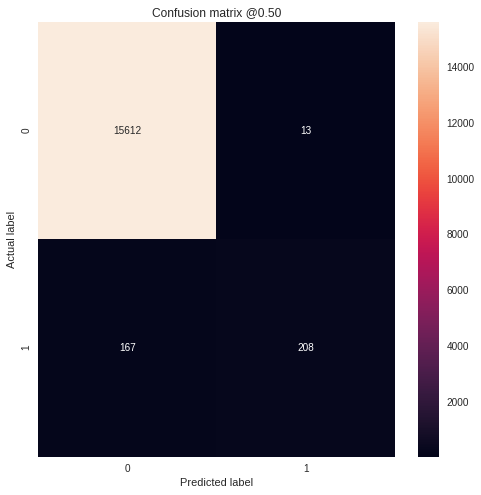

In [67]:
plot_cm(y_test, predictions)

In [68]:
if (notifyStatus): status_notify("Phase 5 Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [69]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 2:59:06.612457
